In [1]:
import logging
from pytorch_lightning.loggers import WandbLogger
import numpy as np
import pypolychord
import wandb
import swyft
import torch
import anesthetic
from anesthetic import MCMCSamples
import os

In [2]:
try:
    from mpi4py import MPI
    comm_gen = MPI.COMM_WORLD
    rank_gen = comm_gen.Get_rank()
    size_gen = comm_gen.Get_size()
except ImportError:
    print("mpi4py not installed, please install it to run this code.")
    rank_gen = 0
    size_gen = 1


In [3]:
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from PolySwyft.PolySwyft_Network import Network
from PolySwyft.PolySwyft_Post_Analysis import plot_analysis_of_NSNRE
from PolySwyft.PolySwyft_Settings import PolySwyft_Settings
from PolySwyft.PolySwyft_Simulator_MultiGauss import Simulator
from PolySwyft.utils import reload_data_for_plotting, select_weighted_contour, resimulate_deadpoints
from PolySwyft.PolySwyft_Dataloader import PolySwyftDataModule

In [4]:
root="PolySwyft_notebook"
polyswyftSettings = PolySwyft_Settings(root)
trainer_kwargs = {"accelerator": 'cpu',
                  "devices": 1,
                  "num_nodes": 1,
                  #"strategy": "ddp",
                  "max_epochs": 1000,
                  "log_every_n_steps": 1,
                  "precision": 64,
                  "enable_progress_bar": True,
                  "default_root_dir": root,
                  "callbacks": [],
                  "deterministic": True,
                  }
polyswyftSettings.trainer_kwargs = trainer_kwargs
polyswyftSettings.early_stopping_patience = 3
seed_everything(polyswyftSettings.seed, workers=True)
logging.basicConfig(filename=polyswyftSettings.logger_name, level=logging.INFO,
                    filemode="w")
logger = logging.getLogger()
polyswyftSettings.logger = logger
logger.info('Started')

Global seed set to 234


In [5]:
 #### instantiate swyft simulator
polyswyftSettings.num_features = 2
polyswyftSettings.num_features_dataset = 3
polyswyftSettings.NRE_num_retrain_rounds = 1

d = polyswyftSettings.num_features_dataset
n = polyswyftSettings.num_features

m = torch.randn(d) * 3  # mean vec of dataset
M = torch.randn(size=(d, n))  # transform matrix of dataset to parameter vee
C = torch.eye(d)  # cov matrix of dataset
# C very small, or Sigma very big
mu = torch.zeros(n)  # mean vec of parameter prior
Sigma = 100 * torch.eye(n)  # cov matrix of parameter prior
sim = Simulator(polyswyftSettings=polyswyftSettings, m=m, M=M, C=C, mu=mu, Sigma=Sigma)
polyswyftSettings.model = sim.model  # lsbi model

In [6]:
# generate training dat and obs
obs = swyft.Sample(x=torch.tensor(sim.model.evidence().rvs()[None, :]))
n_per_core = polyswyftSettings.n_training_samples // size_gen
if rank_gen == 0:
    n_per_core += polyswyftSettings.n_training_samples % size_gen
seed_everything(polyswyftSettings.seed + rank_gen, workers=True)
deadpoints = sim.sample(n_per_core, targets=[polyswyftSettings.targetKey])[
    polyswyftSettings.targetKey]
comm_gen.Barrier()
seed_everything(polyswyftSettings.seed, workers=True)
deadpoints = comm_gen.allgather(deadpoints)
deadpoints = np.concatenate(deadpoints, axis=0)
comm_gen.Barrier()

/Users/hikarukilian/LFIenv/lib/python3.10/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
Global seed set to 234


  0%|          | 0/10000 [00:00<?, ?it/s]

Global seed set to 234


In [7]:
### generate true posterior for comparison
cond = {polyswyftSettings.obsKey: obs[polyswyftSettings.obsKey].numpy().squeeze()}
full_joint = sim.sample(polyswyftSettings.n_weighted_samples, conditions=cond)
posterior = full_joint[polyswyftSettings.posteriorsKey]
weights = np.ones(shape=len(posterior))  # direct samples from posterior have weights 1
params_labels = {i: rf"${polyswyftSettings.targetKey}_{i}$" for i in range(polyswyftSettings.num_features)}
mcmc_true = MCMCSamples(
    data=posterior, weights=weights.squeeze(), labels=params_labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
#### instantiate swyft networ
network = Network(polyswyftSettings=polyswyftSettings, obs=obs)

#### create helper function for polyswyft cycle
def create_callbacks() -> list:
    early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.,
                                            patience=polyswyftSettings.early_stopping_patience, mode='min')
    lr_monitor = LearningRateMonitor(logging_interval='step')
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          filename='NRE_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
    return [early_stopping_callback, lr_monitor, checkpoint_callback]

def lr_round_scheduler(rd: int)-> float:
    lr = polyswyftSettings.learning_rate_init * (polyswyftSettings.learning_rate_decay ** (polyswyftSettings.early_stopping_patience*rd))
    return lr

def deadpoints_processing(deadpoints: anesthetic.NestedSamples)->anesthetic.NestedSamples:
    return deadpoints

In [9]:
 #### set up polychord settings
polyset = pypolychord.PolyChordSettings(polyswyftSettings.num_features, nDerived=polyswyftSettings.nderived)
polyset.file_root = "samples"
polyset.base_dir = polyswyftSettings.root
polyset.seed = polyswyftSettings.seed
polyset.nfail = polyswyftSettings.n_training_samples
polyset.nlive = 100*polyswyftSettings.num_features

In [10]:
if not polyswyftSettings.only_plot_mode:
    for rd in range(polyswyftSettings.NRE_start_from_round, polyswyftSettings.NRE_num_retrain_rounds+1):
        logger.info("training network round: " + str(rd))
        if polyswyftSettings.NRE_start_from_round > 0: # load previous samples and network
            root = f"{polyswyftSettings.root}/{polyswyftSettings.child_root}_{rd-1}"
            deadpoints = anesthetic.read_chains(root=f"{root}/{polyset.file_root}")
            deadpoints = deadpoints.iloc[:, :polyswyftSettings.num_features].to_numpy()
            network.load_state_dict(torch.load(f"{root}/{polyswyftSettings.neural_network_file}"))

        ### update root
        root = f"{polyswyftSettings.root}/{polyswyftSettings.child_root}_{rd}"
        ### create root folder ###
        try:
            os.makedirs(root)
        except OSError:
            logger.info("root folder already exists!")

        ####conditional resimulate deadpoints with swyft
        resimulate_deadpoints(deadpoints=deadpoints, polyswyftSettings=polyswyftSettings, sim=sim, rd=rd)
        dm = PolySwyftDataModule(polyswyftSettings=polyswyftSettings,rd=rd,
                                 **polyswyftSettings.dm_kwargs)

        ###prepare network
        learning_rate = lr_round_scheduler(rd) #adjust learning rate between round (optional)
        network.optimizer_init.optim_args = dict(lr=learning_rate)
        ####set network to train mode
        network.train()

        #prepare wandb logger
        try:
            polyswyftSettings.wandb_kwargs.pop("finish")
        except KeyError:
            print("Key not found")
        polyswyftSettings.wandb_kwargs["name"] = f"{polyswyftSettings.child_root}_{rd}"
        polyswyftSettings.wandb_kwargs["save_dir"] = f"{polyswyftSettings.root}/{polyswyftSettings.child_root}_{rd}"
        wandb_logger = WandbLogger(**polyswyftSettings.wandb_kwargs)
        ###prepare trainer
        try:
            polyswyftSettings.trainer_kwargs.pop("callbacks")
        except KeyError:
            print("Key not found")

        #### train network
        trainer = swyft.SwyftTrainer(**polyswyftSettings.trainer_kwargs, logger=wandb_logger, callbacks=create_callbacks())
        trainer.fit(network, dm)
        wandb.finish()

        if rank_gen == 0:
            torch.save(network.state_dict(), f"{root}/{polyswyftSettings.neural_network_file}")
            torch.save(network.optimizers().state_dict(), f"{root}/{polyswyftSettings.optimizer_file}")

        #### prepare network for polychord
        network.eval()

        # run polychord
        polyset.base_dir = root
        comm_gen.barrier()
        pypolychord.run_polychord(loglikelihood=network.logLikelihood,
                                  nDims=polyswyftSettings.num_features,
                                  nDerived=polyswyftSettings.nderived, settings=polyset,
                                  prior=network.prior, dumper=network.dumper)

        comm_gen.Barrier()
        deadpoints = anesthetic.read_chains(root=f"{root}/{polyset.file_root}")

        #run dynamic nested sampling round 2 here if you want
        ##### Polychord run 2 #####
        if polyswyftSettings.use_livepoint_increasing:
            ### choose contour to increase livepoints ###
            index = select_weighted_contour(deadpoints,
                                            threshold=1 - polyswyftSettings.livepoint_increase_posterior_contour)
            logL = deadpoints.iloc[index, :].logL

            try:
                os.makedirs(f"{root}/{polyswyftSettings.increased_livepoints_fileroot}")
            except OSError:
                logger.info("root folder already exists!")

            ### run polychord round 2 ###
            polyset.base_dir = f"{root}/{polyswyftSettings.increased_livepoints_fileroot}"
            polyset.nlives = {logL: polyswyftSettings.n_increased_livepoints}
            comm_gen.Barrier()
            pypolychord.run_polychord(loglikelihood=network.logLikelihood,
                                      nDims=polyswyftSettings.num_features,
                                      nDerived=polyswyftSettings.nderived, settings=polyset,
                                      prior=network.prior, dumper=network.dumper)
            comm_gen.Barrier()
            polyset.nlives = {}
            deadpoints = anesthetic.read_chains(
                root=f"{root}/{polyswyftSettings.increased_livepoints_fileroot}/{polyset.file_root}")

        #### optional deadpoints post processing
        deadpoints = deadpoints_processing(deadpoints)

        #prepare data for next round
        deadpoints = deadpoints.iloc[:, :polyswyftSettings.num_features].to_numpy()


wandb: Currently logged in as: khs40 (nsnre). Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                   | Params
---------------------------------------------------
0 | network | LogRatioEstimator_Ndim | 68.0 K
---------------------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.544     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/hikarukilian/LFIenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/hikarukilian/LFIenv/lib/python3.10/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/hikarukilian/LFIenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may b

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
lr-Adam,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_loss,█▂▂▄▂▁▃▁▂▁▃▁▂▃▂▁▂▃▅▁▂▃▄▄▂▁▁▃▁▁▂▂▃▃▂▃▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▅▃▃▅▁▄█▁
epoch,7
lr-Adam,0.00093
train_loss,-1.3784
trainer/global_step,999
val_loss,-1.31349


PolyChord: MPI is already initilised, not initialising, and will not finalize
Last dead point: [ -4.08601546 -12.39760633   6.40385578   6.49756231]

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     200
nDims    :       2
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to PolySwyft_notebook/round_0/samples.resume

Resuming from previous run
number of repeats:           10
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         2779                              |
| log(Z) =            0.53425 +/-            0.15971 |
|____________________________________________________|
Key not found


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                   | Params
---------------------------------------------------
0 | network | LogRatioEstimator_Ndim | 68.0 K
---------------------------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.544     Total estimated model params size (MB)


Key not found


Sanity Checking: 0it [00:00, ?it/s]

/Users/hikarukilian/LFIenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/hikarukilian/LFIenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇███████
lr-Adam,███████▇▇▇▇▇▇▇▅▅▅▅▅▅▄▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,▅▄▃▄▂▅▃▆▅▃█▄▂▄▆▆▄▁▃▂▅▆▃▆▃▂▃▆▄▄▁▃▁▂▃▂▃▁▅▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▅▇▁▅█▁
epoch,5
lr-Adam,0.00092
train_loss,-1.24083
trainer/global_step,959
val_loss,-1.27649


PolyChord: MPI is already initilised, not initialising, and will not finalize
Last dead point: [ -5.44747288 -12.60827028   3.38893419   3.39176979]

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     200
nDims    :       2
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to PolySwyft_notebook/round_1/samples.resume

Resuming from previous run
number of repeats:           10
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         2738                              |
| log(Z) =           -2.37180 +/-            0.15700 |
|____________________________________________________|


In [11]:
root_storage, network_storage, samples_storage, dkl_storage = reload_data_for_plotting(
    polyswyftSettings=polyswyftSettings,
    network=network,
    polyset=polyset,
    until_round=polyswyftSettings.NRE_num_retrain_rounds)


In [14]:

import matplotlib.pyplot as plt
from anesthetic import make_2d_axes
from PolySwyft.utils import compute_KL_compression, compute_KL_divergence_truth


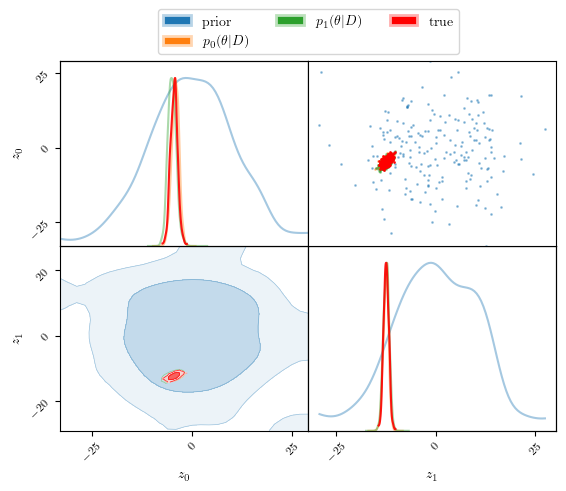

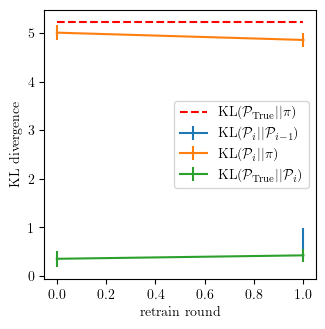

In [26]:
if rank_gen == 0:
    from matplotlib import rc
    rc('text', usetex=True)
    rc('font', family='serif')
    
    # set up labels for plotting
    params_idx = [i for i in range(0, polyswyftSettings.num_features)]
    params_labels = {i: rf"${polyswyftSettings.targetKey}_{i}$" for i in range(polyswyftSettings.num_features)}
    
    dkl_storage_true = {}
    dkl_compression_storage = {}
    # triangle plot
    if polyswyftSettings.plot_triangle_plot:
        kinds = {'lower': 'kde_2d', 'diagonal': 'kde_1d', 'upper': "scatter_2d"}
        fig, axes = make_2d_axes(params_idx, labels=params_labels, lower=True, diagonal=True, upper=True,
                                 ticks="outer")
        if polyswyftSettings.triangle_start == 0:
            first_round_samples = samples_storage[0]
            # load prior from last round
            prior = first_round_samples.prior()
            prior.plot_2d(axes=axes, alpha=0.4, label="prior", kinds=kinds)
        for rd in range(polyswyftSettings.triangle_start, polyswyftSettings.NRE_num_retrain_rounds + 1):
            nested = samples_storage[rd]
            nested.plot_2d(axes=axes, alpha=0.4, label=fr"$p_{rd}(\theta|D)$",
                           kinds=kinds)
        if mcmc_true is not None:
            mcmc_true.plot_2d(axes=axes, alpha=0.9, label="true", color="red",
                                   kinds=kinds)
    
        axes.iloc[-1, 0].legend(bbox_to_anchor=(len(axes) / 2, len(axes)), loc='lower center',
                                ncols=polyswyftSettings.NRE_num_retrain_rounds + 2)
        plt.show()
        fig.savefig(f"{root}/NRE_triangle_posterior.pdf")
    
    # KL divergence plot
    if polyswyftSettings.plot_KL_divergence:
        for rd in range(0, polyswyftSettings.NRE_num_retrain_rounds + 1):
            DKL = compute_KL_compression(samples_storage[rd], polyswyftSettings)
            dkl_compression_storage[rd] = DKL
            if mcmc_true is not None:
                previous_network = network_storage[rd]
                KDL_true = compute_KL_divergence_truth(polyswyftSettings=polyswyftSettings,
                                                       previous_network=previous_network.eval(),
                                                       true_posterior=mcmc_true.copy(), obs=obs,
                                                       previous_samples=samples_storage[rd])
                dkl_storage_true[rd] = KDL_true
        plt.figure(figsize=(3.5, 3.5))
    
        ### plot KL(P_i||P_{i-1})
        plt.errorbar(x=[i for i in range(1, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                     y=[dkl_storage[i][0] for i in range(1, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                     yerr=[dkl_storage[i][1] for i in range(1, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                     label=r"$\mathrm{KL}(\mathcal{P}_i||\mathcal{P}_{i-1})$")
        ### plot KL(P_i||Pi)
        plt.errorbar(x=[i for i in range(0, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                     y=[dkl_compression_storage[i][0] for i in range(0, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                     yerr=[dkl_compression_storage[i][1] for i in range(0, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                     label=r"$\mathrm{KL}(\mathcal{P}_i||\pi)$")
    
        if mcmc_true is not None and polyswyftSettings.model is not None:
            ### plot KL(P_true||P_i)
            plt.errorbar(x=[i for i in range(0, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                         y=[dkl_storage_true[i][0] for i in range(0, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                         yerr=[dkl_storage_true[i][1] for i in range(0, polyswyftSettings.NRE_num_retrain_rounds + 1)],
                         label=r"$\mathrm{KL}(\mathcal{P}_{\mathrm{True}}||\mathcal{P}_i)$",linestyle="--")
            ### plot KL(P_true||Pi)
            mcmc_true_samples = mcmc_true.iloc[:, :polyswyftSettings.num_features].to_numpy()
            logPi = polyswyftSettings.model.prior().logpdf(mcmc_true_samples)
            logP = polyswyftSettings.model.posterior(obs[polyswyftSettings.obsKey].squeeze()).logpdf(mcmc_true_samples)
            dkl_compression_truth = 1/logP.shape[0]*((logP - logPi).sum())
            plt.hlines(y=dkl_compression_truth, xmin=0, xmax=polyswyftSettings.NRE_num_retrain_rounds, color="red",
                       label=r"$\mathrm{KL}(\mathcal{P}_{\mathrm{True}}||\pi)$",linestyle="--")
    
        plt.legend()
        plt.xlabel("retrain round")
        plt.ylabel("KL divergence")
        plt.savefig(f"{root}/kl_divergence.pdf", dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()